In [1]:


import openmm as mm
import openmm.app as app
import openmm.unit as unit
import numpy as np
import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Deserialize the System, Integrator, and State from XML files
# -----------------------------------------------------------------------------
# These files were previously saved in the previous script.

with open('../insert_molecule/O2_system.xml') as sys_file:
    system = mm.XmlSerializer.deserialize(sys_file.read())

with open('../insert_molecule/O2_integrator.xml') as int_file:
    integrator = mm.XmlSerializer.deserialize(int_file.read())

with open('../insert_molecule/O2_state.xml') as st_file:
    state = mm.XmlSerializer.deserialize(st_file.read())

# -----------------------------------------------------------------------------
# 2) Load the Topology from a PDB file
# -----------------------------------------------------------------------------
pdb = app.PDBFile('../insert_molecule/O2_alchemical_insertion_last.pdb')
topology = pdb.topology


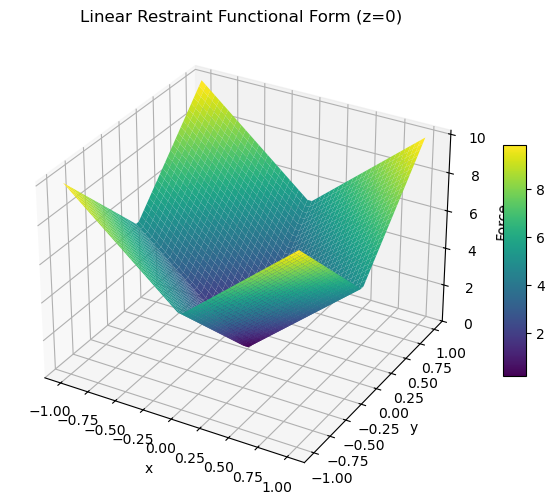

In [2]:


# Define the function
def linear_restraint(x, y, z, x0, y0, z0, k):
    return k * (abs(x - x0) + abs(y - y0) + abs(z - z0))

# Parameters
x0, y0, z0 = 0, 0, 0  # Center
k = 5.0  # Force constant

# Create a grid of points
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)
z = np.linspace(-1, 1, 50)
X, Y, Z = np.meshgrid(x, y, z)

# Compute the function values
F = linear_restraint(X, Y, Z, x0, y0, z0, k)

# Plot the function for a fixed z-plane (e.g., z=0)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
Z_plane = 0  # Fix z=0
F_plane = linear_restraint(X[:, :, 25], Y[:, :, 25], Z_plane, x0, y0, z0, k)
surf = ax.plot_surface(X[:, :, 25], Y[:, :, 25], F_plane, cmap='viridis')

# Add labels and color bar
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Force')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.title('Linear Restraint Functional Form (z=0)')
plt.show()

In [3]:
# -----------------------------------------------------------------------------
# 3) Create a CustomExternalForce to restrain O2 near the center of the system
# -----------------------------------------------------------------------------
# We'll define a linear "taxicab" norm restraint, summing up |x - x0| + |y - y0| + |z - z0|.
# The rest of the system is unaffected; only the specified O2 atoms are restrained.

centerforce = mm.CustomExternalForce("k * (abs(x - x0) + abs(y - y0) + abs(z - z0))")

# 3.a) Add a global parameter for the force constant 'k'.
#      We'll use 5 kJ/mol/Å for demonstration.
centerforce.addGlobalParameter("k", 5.0 * unit.kilojoule / (unit.mole * unit.angstrom))

# 3.b) Per-particle parameters: each particle we add can have a unique (x0, y0, z0).
centerforce.addPerParticleParameter("x0")
centerforce.addPerParticleParameter("y0")
centerforce.addPerParticleParameter("z0")

# 3.c) Compute the mean x, y, z of all atoms from the current state's positions.
positions_array = np.array(state.getPositions(asNumpy=True) / unit.nanometer)
xmean = np.mean(positions_array[:, 0]) * unit.nanometer
ymean = np.mean(positions_array[:, 1]) * unit.nanometer
zmean = np.mean(positions_array[:, 2]) * unit.nanometer

# 3.d) Add the two O2 atoms (assume their indices are 1728 and 1729) to the force.
#      Each gets the same (x0, y0, z0) = (xmean, ymean, zmean).
centerforce.addParticle(1728, mm.Vec3(xmean, ymean, zmean))
centerforce.addParticle(1729, mm.Vec3(xmean, ymean, zmean))

# Add the force to the system so it will take effect in the simulation.
system.addForce(centerforce)

# -----------------------------------------------------------------------------
# 4) Create a Simulation, set the initial State, and add Reporters
# -----------------------------------------------------------------------------
# Note: For CPU or other platforms, you can specify them in Simulation(...).

simulation = app.Simulation(topology, system, integrator)
simulation.context.setState(state)

# 4.a) Prepare MD parameters and reporter intervals
mdsteps   = 55000   # 110 ps total at 2 fs per step (55000 * 2 fs = 110 ps)
dcdperiod =    50   # Write a DCD frame every 50 steps (~0.1 ps)
logperiod =    50   # Write log info every 50 steps (~0.1 ps)

# 4.b) We add reporters to track progress to stdout
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        logperiod,
        step=True, time=True,
        potentialEnergy=True, kineticEnergy=True, totalEnergy=True,
        temperature=True, progress=True, volume=True, density=True,
        remainingTime=True, speed=True,
        totalSteps=mdsteps,
        separator='\t'
    )
)

# Also log to a file named "O2_restraints.log"
simulation.reporters.append(
    app.StateDataReporter(
        'O2_restraints.log',
        logperiod,
        step=True, time=True,
        potentialEnergy=True, kineticEnergy=True, totalEnergy=True,
        temperature=True, progress=True, volume=True, density=True,
        remainingTime=True, speed=True,
        totalSteps=mdsteps,
        separator='\t'
    )
)

# And save the trajectory to "O2_restraints.dcd"
simulation.reporters.append(
    app.DCDReporter('./O2_restraints.dcd', dcdperiod)
)

# -----------------------------------------------------------------------------
# 5) Run the simulation for 5000 steps (~10 ps), enough to pull O2 to the center
# -----------------------------------------------------------------------------
print("Starting simulation with linear restraint pulling O2 to center.")
simulation.step(5000)
print("Simulation complete.")

Starting simulation with linear restraint pulling O2 to center.
#"Progress (%)"	"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Kinetic Energy (kJ/mole)"	"Total Energy (kJ/mole)"	"Temperature (K)"	"Box Volume (nm^3)"	"Density (g/mL)"	"Speed (ns/day)"	"Time Remaining"
10.1%	5550	11.100000000000376	718438.9187632186	4322.928143629804	722761.8469068484	300.4500135884637	19.244711397196216	0.8981303785117438	0	--
10.2%	5600	11.20000000000041	718361.2409005789	4320.586751284893	722681.8276518638	300.28728329583066	19.138134162522803	0.9031319241851675	235	0:36
10.3%	5650	11.300000000000443	718373.2649297523	4334.3807493094355	722707.6456790618	301.2459869236067	19.07587884878336	0.9060793512334285	307	0:27
10.4%	5700	11.400000000000476	718411.3679570961	4277.899630804197	722689.2675879003	297.3204641625132	19.07587884878336	0.9060793512334285	344	0:24
10.5%	5750	11.50000000000051	718320.9021367836	4313.539468285278	722634.4416050689	299.79748651858927	19.07587884878336	0.9060793512334285	3

In [4]:
simulation.system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x105ec0cf0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x127bc2040> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x127bb06c0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x127bb07e0> >,
 <openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x105ea7510> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x1275f4a20> >]

In [5]:
# -----------------------------------------------------------------------------
# 1) Remove the old 'centerforce' from the System
# -----------------------------------------------------------------------------
# The centerforce is at index 5, you can remove it directly:
simulation.system.removeForce(5)

# -----------------------------------------------------------------------------
# 2) Create a flat-well harmonic restraint along the z-axis
# -----------------------------------------------------------------------------

flatzforce = mm.CustomExternalForce(
    """
    k * (pz^2);
    pz = max(0, delta);
    delta = r - width;
    r = abs(periodicdistance(x, y, z, x, y, z0));
    """
)

# Set global parameters
flatzforce.addGlobalParameter('k', 1.0 * unit.kilojoule / (unit.mole * unit.angstrom**2))
flatzforce.addGlobalParameter('width', 0.3 * unit.nanometer)

# Add a per-particle parameter for the target z0. 
#   (In this example, 'x' and 'y' aren't changed, so the difference 
#    is measured only in the XY-plane vs. z0.)
flatzforce.addPerParticleParameter('z0')

# Suppose zmean was previously computed as the average z-position of O2 atoms
# For demonstration, we apply the same z0 to both O2 atoms (indices 1728, 1729).
flatzforce.addParticle(1728, [zmean])
flatzforce.addParticle(1729, [zmean])

# Add this force to the system
simulation.system.addForce(flatzforce)

# -----------------------------------------------------------------------------
# 3) Re-initialize the Simulation context 
# -----------------------------------------------------------------------------


# First, grab current positions/velocities so we can restore them post-reinit.
positions = simulation.context.getState(getPositions=True).getPositions()
velocities = simulation.context.getState(getVelocities=True).getVelocities()

# Re-initialize, then reset positions and velocities.
simulation.context.reinitialize()
simulation.context.setPositions(positions)
simulation.context.setVelocities(velocities)

# -----------------------------------------------------------------------------
# 4) Run the simulation for ~100 ps
# -----------------------------------------------------------------------------
# Assuming 2 fs per step, 50,000 steps ~ 100 ps.
print("Applying flat-well harmonic restraint and running 100 ps...")
simulation.step(50000)
print("Simulation complete!")

Applying flat-well harmonic restraint and running 100 ps...
0.1%	50	0.10000000000000007	-456888.18894732965	6469.090059174225	-450419.0988881554	449.61149748649063	18.16179140639827	0.9516825485300963	-44.1	23:56:25
0.2%	100	0.20000000000000015	-456687.4701671784	5944.55500001926	-450742.91516715917	413.1555212558964	18.232724813182376	0.9479800802465069	-43.7	23:56:23
0.3%	150	0.3000000000000002	-456799.6551027193	5785.207471861504	-451014.4476308578	402.0806281719494	18.374319555649866	0.940674830388395	-43.2	23:56:21
0.4%	200	0.4000000000000003	-456813.05428627995	5521.118662182242	-451291.9356240977	383.7260583478782	18.571416114593358	0.9306915436530008	-42.7	23:56:19
0.5%	250	0.5000000000000003	-456934.65823059366	5403.119679491967	-451531.5385511017	375.52495141877955	18.55811909811737	0.9313583903697714	-42.3	23:56:17
0.5%	300	0.6000000000000004	-457129.3999681039	5438.74593463901	-451690.6540334649	378.00102978219354	18.688696252197182	0.9248510275017734	-41.8	23:56:15
0.6%	35